In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
# Take my NVidia GPU into use
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

2023-04-30 02:05:08.199395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9g4qkou9 because the default path (/home/harsh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from tensorflow.python.client import device_lib 
os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 931521595729475197
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 991832818922184608
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [7]:
files1 = glob.glob("./parkinsons/*Ju**Co*.txt")
files2 = glob.glob("./parkinsons/*Ju**Pt*.txt")
files1j = glob.glob("./parkinsons/*Ga**Co*.txt")
files2j = glob.glob("./parkinsons/*Ga**Pt*.txt")
files1s = glob.glob("./parkinsons/*Si**Co*.txt")
files2s = glob.glob("./parkinsons/*Si**Pt*.txt")
# files=files1+files2
# shuffle(files)

In [8]:
print(len(files1))
print(len(files2))     
print(len(files1j))
print(len(files2j))     
print(len(files1s))
print(len(files2s))     

25
104
38
75
29
35


In [9]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [10]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [11]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [12]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients.append( Patient(data, ispark) )
        
        j=j+75

In [13]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1.append( Patient(data, ispark) )
        
        j=j+75

In [14]:
len(patients)

2749

In [15]:
len(patients1)


12064

In [16]:
shuffle(patients)
shuffle(patients1)

In [17]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [18]:
print(len(train))
print(len(test))

11850
2963


In [19]:
shuffle(train)
shuffle(test)

In [20]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [21]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [22]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[-0.69637564, -0.68513435, -0.60030605, ...,  0.41346634,
        -1.12004968,  0.86772799],
       [-0.69637564, -0.68513435, -0.60030605, ...,  0.47119568,
        -1.12004968,  0.87264783],
       [-0.69637564, -0.68513435, -0.60030605, ...,  0.64232194,
        -1.12004968,  0.89888694],
       ...,
       [-0.69637564, -0.68513435, -0.63966869, ...,  1.83195868,
        -1.12691365,  0.53071944],
       [-0.69637564, -0.68513435, -0.63966869, ...,  1.90618212,
        -1.12691365,  0.50366036],
       [-0.69637564, -0.65503459, -0.63966869, ...,  1.94329384,
        -1.1205988 ,  0.47550798]])

In [23]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [24]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [25]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [26]:
X_scaled_arr_train.shape

(11850, 150, 18)

In [27]:
Y_arr_train.shape

(11850,)

In [28]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [29]:
import numpy as np

In [32]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10|0, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22_150_cross_test.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [33]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

Epoch 1/500
474/474 [==============================] - 176s 350ms/step - loss: 3.2582 - accuracy: 0.2033 - val_loss: 0.5949 - val_accuracy: 0.7570

Epoch 00001: val_accuracy improved from -inf to 0.75696, saving model to ./Model/model_LSTM22_150_cross_test.v


2023-04-30 02:13:18.948941: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 2/500
474/474 [==============================] - 157s 332ms/step - loss: 0.5604 - accuracy: 0.7551 - val_loss: 0.4532 - val_accuracy: 0.8215

Epoch 00002: val_accuracy improved from 0.75696 to 0.82152, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 3/500
474/474 [==============================] - 157s 331ms/step - loss: 0.4566 - accuracy: 0.8200 - val_loss: 0.4224 - val_accuracy: 0.8228

Epoch 00003: val_accuracy improved from 0.82152 to 0.82278, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 4/500
474/474 [==============================] - 156s 329ms/step - loss: 0.4334 - accuracy: 0.8193 - val_loss: 0.3994 - val_accuracy: 0.8371

Epoch 00004: val_accuracy improved from 0.82278 to 0.83713, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 5/500
474/474 [==============================] - 156s 328ms/step - loss: 0.4194 - accuracy: 0.8287 - val_loss: 0.3920 - val_accuracy: 0.8481

Epoch 00005: val_accuracy improved from 0.83713 to 0.84810, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 6/500
474/474 [==============================] - 156s 330ms/step - loss: 0.3713 - accuracy: 0.8459 - val_loss: 0.3250 - val_accuracy: 0.8650

Epoch 00006: val_accuracy improved from 0.84810 to 0.86498, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 7/500
474/474 [==============================] - 157s 332ms/step - loss: 0.3566 - accuracy: 0.8606 - val_loss: 0.2912 - val_accuracy: 0.8924

Epoch 00007: val_accuracy improved from 0.86498 to 0.89241, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 8/500
474/474 [==============================] - 159s 335ms/step - loss: 0.3117 - accuracy: 0.8897 - val_loss: 0.2561 - val_accuracy: 0.8937

Epoch 00008: val_accuracy improved from 0.89241 to 0.89367, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 9/500
474/474 [==============================] - 156s 328ms/step - loss: 0.2834 - accuracy: 0.8967 - val_loss: 0.3372 - val_accuracy: 0.8633

Epoch 00009: val_accuracy did not improve from 0.89367
Epoch 10/500
474/474 [==============================] - 157s 332ms/step - loss: 0.3225 - accuracy: 0.8782 - val_loss: 0.2063 - val_accuracy: 0.9198

Epoch 00010: val_accuracy improved from 0.89367 to 0.91983, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 11/500
474/474 [==============================] - 156s 329ms/step - loss: 0.2670 - accuracy: 0.9161 - val_loss: 0.1799 - val_accuracy: 0.9468

Epoch 00011: val_accuracy improved from 0.91983 to 0.94684, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 12/500
474/474 [==============================] - 158s 333ms/step - loss: 0.5474 - accuracy: 0.7655 - val_loss: 0.3083 - val_accuracy: 0.8781

Epoch 00012: val_accuracy did not improve from 0.94684
Epoch 13/500
474/474 [==============================] - 157s 332ms/step - loss: 0.3118 - accuracy: 0.8735 - val_loss: 0.2531 - val_accuracy: 0.9004

Epoch 00013: val_accuracy did not improve from 0.94684
Epoch 14/500
474/474 [==============================] - 156s 329ms/step - loss: 0.2562 - accuracy: 0.8939 - val_loss: 0.2225 - val_accuracy: 0.9232

Epoch 00014: val_accuracy did not improve from 0.94684
Epoch 15/500
474/474 [==============================] - 156s 329ms/step - loss: 0.2516 - accuracy: 0.9012 - val_loss: 0.2166 - val_accuracy: 0.9380

Epoch 00015: val_accuracy did not improve from 0.94684
Epoch 16/500
474/474 [==============================] - 158s 334ms/step - loss: 0.2167 - accuracy: 0.9286 - val_loss: 0.1943 - val_accuracy: 0.9519

Epoch 00016: val_accuracy improved 

INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 17/500
474/474 [==============================] - 156s 329ms/step - loss: 0.2198 - accuracy: 0.9184 - val_loss: 0.2070 - val_accuracy: 0.9473

Epoch 00017: val_accuracy did not improve from 0.95190
Epoch 18/500
474/474 [==============================] - 155s 328ms/step - loss: 0.1707 - accuracy: 0.9507 - val_loss: 0.1767 - val_accuracy: 0.9624

Epoch 00018: val_accuracy improved from 0.95190 to 0.96245, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 19/500
474/474 [==============================] - 155s 328ms/step - loss: 0.1739 - accuracy: 0.9542 - val_loss: 0.1412 - val_accuracy: 0.9650

Epoch 00019: val_accuracy improved from 0.96245 to 0.96498, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 20/500
474/474 [==============================] - 156s 329ms/step - loss: 0.1531 - accuracy: 0.9609 - val_loss: 0.2494 - val_accuracy: 0.9599

Epoch 00020: val_accuracy did not improve from 0.96498
Epoch 21/500
474/474 [==============================] - 156s 330ms/step - loss: 0.1609 - accuracy: 0.9615 - val_loss: 0.1752 - val_accuracy: 0.9582

Epoch 00021: val_accuracy did not improve from 0.96498
Epoch 22/500
474/474 [==============================] - 157s 331ms/step - loss: 0.1558 - accuracy: 0.9624 - val_loss: 0.1139 - val_accuracy: 0.9696

Epoch 00022: val_accuracy improved from 0.96498 to 0.96962, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 23/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1310 - accuracy: 0.9660 - val_loss: 0.2098 - val_accuracy: 0.9730

Epoch 00023: val_accuracy improved from 0.96962 to 0.97300, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 24/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1443 - accuracy: 0.9680 - val_loss: 0.1289 - val_accuracy: 0.9696

Epoch 00024: val_accuracy did not improve from 0.97300
Epoch 25/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1349 - accuracy: 0.9664 - val_loss: 0.2166 - val_accuracy: 0.9658

Epoch 00025: val_accuracy did not improve from 0.97300
Epoch 26/500
474/474 [==============================] - 154s 326ms/step - loss: 0.1292 - accuracy: 0.9686 - val_loss: 0.1907 - val_accuracy: 0.9616

Epoch 00026: val_accuracy did not improve from 0.97300
Epoch 27/500
474/474 [==============================] - 157s 332ms/step - loss: 0.1352 - accuracy: 0.9621 - val_loss: 0.1417 - val_accuracy: 0.9751

Epoch 00027: val_accuracy improved from 0.97300 to 0.97511, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 28/500
474/474 [==============================] - 155s 328ms/step - loss: 0.1337 - accuracy: 0.9674 - val_loss: 0.2275 - val_accuracy: 0.9426

Epoch 00028: val_accuracy did not improve from 0.97511
Epoch 29/500
474/474 [==============================] - 157s 330ms/step - loss: 0.1666 - accuracy: 0.9589 - val_loss: 0.1108 - val_accuracy: 0.9781

Epoch 00029: val_accuracy improved from 0.97511 to 0.97806, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 30/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1725 - accuracy: 0.9643 - val_loss: 0.1639 - val_accuracy: 0.9485

Epoch 00030: val_accuracy did not improve from 0.97806
Epoch 31/500
474/474 [==============================] - 157s 332ms/step - loss: 0.1524 - accuracy: 0.9571 - val_loss: 0.1334 - val_accuracy: 0.9705

Epoch 00031: val_accuracy did not improve from 0.97806
Epoch 32/500
474/474 [==============================] - 156s 328ms/step - loss: 0.1070 - accuracy: 0.9712 - val_loss: 0.1415 - val_accuracy: 0.9768

Epoch 00032: val_accuracy did not improve from 0.97806
Epoch 33/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1858 - accuracy: 0.9518 - val_loss: 0.1109 - val_accuracy: 0.9772

Epoch 00033: val_accuracy did not improve from 0.97806
Epoch 34/500
474/474 [==============================] - 154s 326ms/step - loss: 0.1062 - accuracy: 0.9776 - val_loss: 0.1113 - val_accuracy: 0.9814

Epoch 00034: val_accuracy improved 

INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 35/500
474/474 [==============================] - 156s 330ms/step - loss: 0.0966 - accuracy: 0.9792 - val_loss: 0.1160 - val_accuracy: 0.9806

Epoch 00035: val_accuracy did not improve from 0.98143
Epoch 36/500
474/474 [==============================] - 154s 326ms/step - loss: 0.0868 - accuracy: 0.9814 - val_loss: 0.1163 - val_accuracy: 0.9793

Epoch 00036: val_accuracy did not improve from 0.98143
Epoch 37/500
474/474 [==============================] - 154s 326ms/step - loss: 0.1000 - accuracy: 0.9807 - val_loss: 0.1131 - val_accuracy: 0.9819

Epoch 00037: val_accuracy improved from 0.98143 to 0.98186, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 38/500
474/474 [==============================] - 158s 333ms/step - loss: 0.0791 - accuracy: 0.9844 - val_loss: 0.1067 - val_accuracy: 0.9802

Epoch 00038: val_accuracy did not improve from 0.98186
Epoch 39/500
474/474 [==============================] - 156s 329ms/step - loss: 0.0594 - accuracy: 0.9858 - val_loss: 0.5757 - val_accuracy: 0.9283

Epoch 00039: val_accuracy did not improve from 0.98186
Epoch 40/500
474/474 [==============================] - 155s 326ms/step - loss: 0.1381 - accuracy: 0.9564 - val_loss: 0.0780 - val_accuracy: 0.9789

Epoch 00040: val_accuracy did not improve from 0.98186
Epoch 41/500
474/474 [==============================] - 155s 328ms/step - loss: 0.0959 - accuracy: 0.9730 - val_loss: 0.1083 - val_accuracy: 0.9785

Epoch 00041: val_accuracy did not improve from 0.98186
Epoch 42/500
474/474 [==============================] - 156s 328ms/step - loss: 0.0689 - accuracy: 0.9835 - val_loss: 0.0938 - val_accuracy: 0.9819

Epoch 00042: val_accuracy did not i

INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 44/500
474/474 [==============================] - 156s 329ms/step - loss: 0.0851 - accuracy: 0.9814 - val_loss: 0.0946 - val_accuracy: 0.9810

Epoch 00044: val_accuracy did not improve from 0.98228
Epoch 45/500
474/474 [==============================] - 155s 328ms/step - loss: 0.0521 - accuracy: 0.9844 - val_loss: 0.1032 - val_accuracy: 0.9810

Epoch 00045: val_accuracy did not improve from 0.98228
Epoch 46/500
474/474 [==============================] - 154s 325ms/step - loss: 0.0788 - accuracy: 0.9838 - val_loss: 0.0870 - val_accuracy: 0.9823

Epoch 00046: val_accuracy did not improve from 0.98228
Epoch 47/500
474/474 [==============================] - 156s 329ms/step - loss: 0.0549 - accuracy: 0.9854 - val_loss: 0.0979 - val_accuracy: 0.9827

Epoch 00047: val_accuracy improved from 0.98228 to 0.98270, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 48/500
474/474 [==============================] - 157s 332ms/step - loss: 0.0773 - accuracy: 0.9830 - val_loss: 0.0891 - val_accuracy: 0.9840

Epoch 00048: val_accuracy improved from 0.98270 to 0.98397, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 49/500
474/474 [==============================] - 156s 330ms/step - loss: 0.0417 - accuracy: 0.9865 - val_loss: 0.1129 - val_accuracy: 0.9823

Epoch 00049: val_accuracy did not improve from 0.98397
Epoch 50/500
474/474 [==============================] - 156s 328ms/step - loss: 0.0555 - accuracy: 0.9874 - val_loss: 0.0834 - val_accuracy: 0.9831

Epoch 00050: val_accuracy did not improve from 0.98397
Epoch 51/500
474/474 [==============================] - 154s 325ms/step - loss: 0.4260 - accuracy: 0.9278 - val_loss: 0.1356 - val_accuracy: 0.9797

Epoch 00051: val_accuracy did not improve from 0.98397
Epoch 52/500
474/474 [==============================] - 155s 327ms/step - loss: 0.1273 - accuracy: 0.9823 - val_loss: 0.0611 - val_accuracy: 0.9819

Epoch 00052: val_accuracy did not improve from 0.98397
Epoch 53/500
474/474 [==============================] - 155s 327ms/step - loss: 0.0748 - accuracy: 0.9826 - val_loss: 0.0895 - val_accuracy: 0.9806

Epoch 00053: val_accuracy did not i

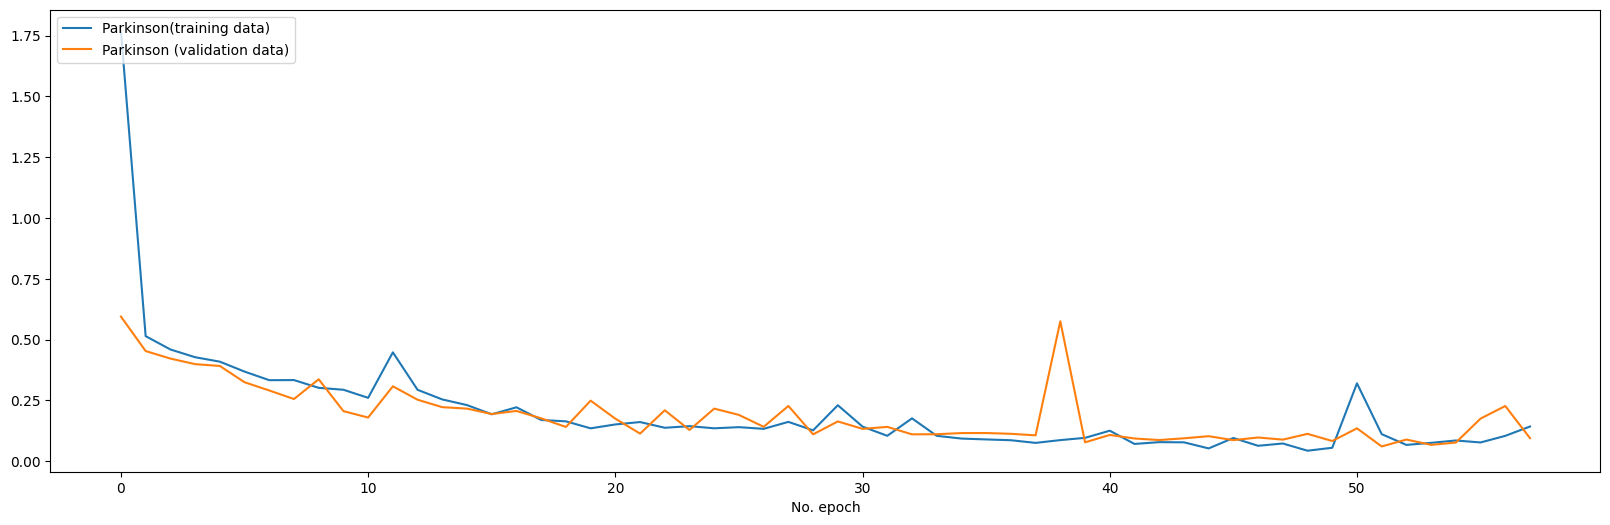

In [34]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

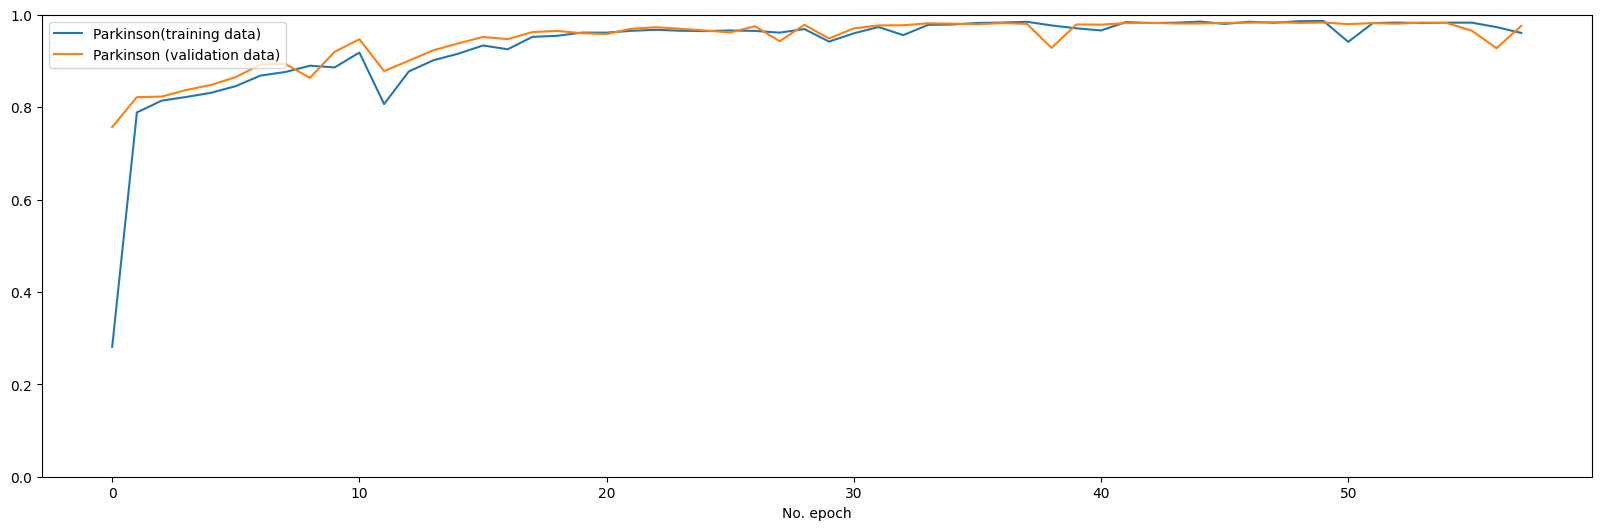

In [35]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

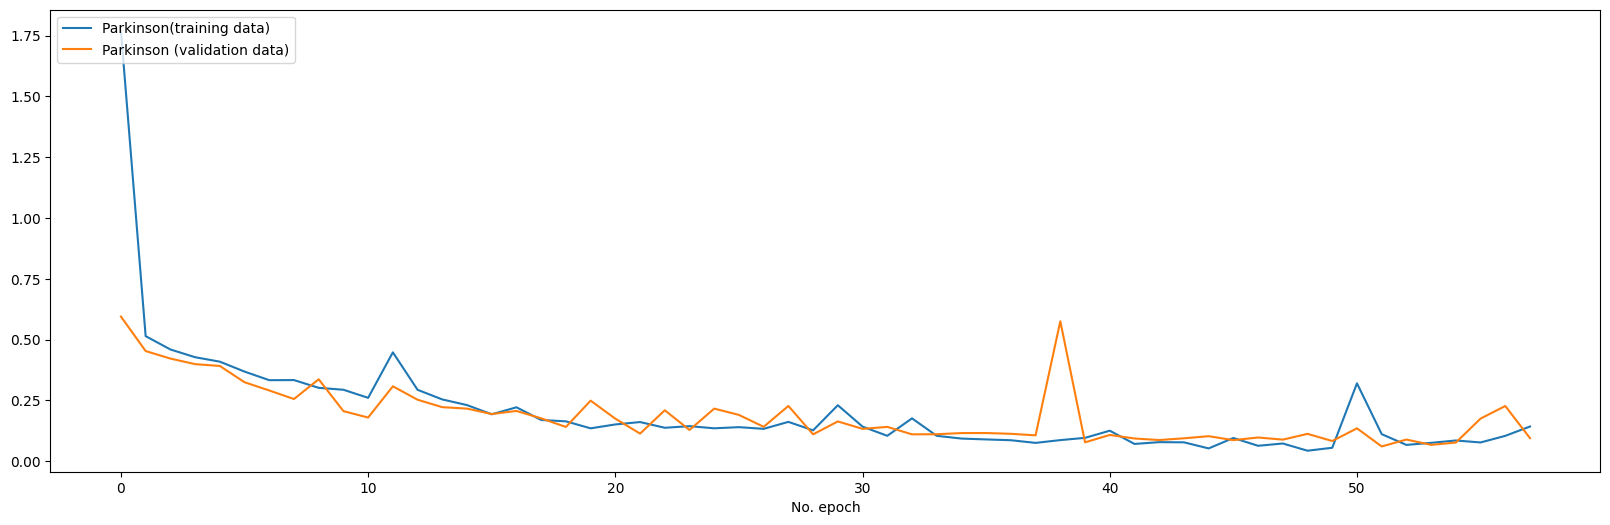

In [36]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [37]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [38]:
accuracy

0.9811002362470469

In [53]:
patients_t=[]
un_used_data_t=[]

for f in files1s:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients_t.append( Patient(data, ispark) )
        
        j=j+75

In [54]:
patients1_t=[]
un_used_data1_t=[]

for f in files2s:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1_t.append( Patient(data, ispark) )
        
        j=j+75

In [55]:
len(patients_t)

4640

In [56]:
test_t= patients+patients1_t

In [57]:
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in test_t:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1
    
X_scaled_list_test_t=[]
Y_list_test_t=[]

for obj in test_t:
    X_scaled_list_test_t = X_scaled_list_test_t + [obj.x_scaled]
    Y_list_test_t = Y_list_test_t + [obj.y]
    
X_scaled_arr_test_t = np.array(X_scaled_list_test_t)
Y_arr_test_t = np.array(Y_list_test_t)

In [58]:
pdt1_t=model.predict(X_scaled_arr_test_t)
pdt1_t.size
classes_x1_t = np.zeros((len(pdt1_t)))
for x in range(len(pdt1_t)):
  if(pdt1_t[x]>0.5):
    classes_x1_t[x]=(1)
  else:
    classes_x1_t[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy_t = accuracy_score(Y_arr_test_t,classes_x1_t )

In [47]:
accuracy_t

0.6335118961440085

In [59]:
accuracy_t

0.6047063752531248